# FOMC-NLP-Arbitrage-Diffusion

# 0. Basic setup

In [7]:
# Global imports
import pandas as pd
from src.ingestor.fomc_data import FOMCDownloader
from src.sentiment.nlp_pipeline import NLPPipeline
from src.market.market_processor import MarketProcessor
from src.tools.logging_config import setup_logging, get_logger
from src.utilities import load_cached_sentiments, print_event_reactions
from scripts.plot_sentiment import plot_fedfunds_aligned

# Logging system initialization
setup_logging()
logger = get_logger("notebook")

# 1. Full Pipeline Execution

### 1.1 FOMC Events Scrapping

FOMC statements and press conference transcripts are already loaded in cache (data/_cache/fomc_data). \
Reruning the following cell is thus not mandatory to perform the other tasks.

Else: \
-> Scrapping running time ~ 1.20 min

In [ ]:
FOMCDownloader(start_year=2013,
               end_year=2016,
               sleep_sec=0.5).sync()

### 1.2 Sentiment analysis NLP Pipeline

The NLP Pipeline has already been run and the results are stored in cache (data/_cache/raw_sentiments). \
The cached results can be used with the argument "use_cache" set to True.

Else : \
-> Scoring running time ~ 1h

In [8]:
nlp_pipe = NLPPipeline()
fomc_raw_events = nlp_pipe.run(use_cache=False)

2025-11-03 11:07:18 INFO  Pipeline run started
2025-11-03 11:07:18 INFO  Gathering statement and press conference files...
2025-11-03 11:07:18 INFO  Found 80 valid meetings with both statement & pressconf
2025-11-03 11:07:18 INFO  Found 80 date pairs to process
2025-11-03 11:07:18 INFO  Processing date 20130320
2025-11-03 11:07:21 INFO  	Scoring statement
2025-11-03 11:07:26 INFO  		Number of chunks : 2 | computed in 5.09 seconds
2025-11-03 11:07:26 INFO  	Scoring press conference


KeyboardInterrupt: 

### 1.3 Market Data Reactions

Maket Data (Raw format) has already been cached (data/_cache/market_data).\
To construct market reactions around FOMC run the following code with previously built fomc_raw_events. \
To used market cached data use the argument "force_fetch" set to False.

Else : \
-> Market Data downloading and reaction computation ~ ...

If you're not running the previous cell please execute this one to load cached sentiment data :

In [9]:
fomc_raw_events = load_cached_sentiments()

In [10]:
processor = MarketProcessor(symbols=["BTCUSDT", "ETHUSDT"],
                            windows=[1,2,5,10,20])
processor.process_events(events=fomc_raw_events,
                         save_computation=True,
                         force_fetch=False)

2025-11-03 11:07:52 INFO  Computing market reactions to FOMC events...
2025-11-03 11:07:52 INFO  Computing reactions for FOMC event on 16-03-2016 for crypto BTCUSDT...
2025-11-03 11:07:54 WARNING HTTP 404 for BTCUSDT on 2016-03-16
2025-11-03 11:07:54 WARNING No data returned for BTCUSDT on 2016-03-16
2025-11-03 11:07:54 ERROR Remote fetch returned no data for BTCUSDT in requested range
2025-11-03 11:07:54 ERROR No market data available for BTCUSDT around 2016-03-16 14:00:00+00:00
2025-11-03 11:07:54 INFO  Computing reactions for FOMC event on 16-03-2016 for crypto ETHUSDT...
2025-11-03 11:07:54 WARNING No local cache found for ETHUSDT at C:\Users\thibc\OneDrive\Documents\Dev\FOMC-NLP-Arbitrage-Diffusion\data\_cache\market_data\ETHUSDT_1m.parquet
2025-11-03 11:07:56 WARNING HTTP 404 for ETHUSDT on 2016-03-16
2025-11-03 11:07:56 WARNING No data returned for ETHUSDT on 2016-03-16
2025-11-03 11:07:56 ERROR Remote fetch returned no data for ETHUSDT in requested range
2025-11-03 11:07:56 ERR

[FOMCEvent(meeting_date='16-03-2016', t_statement='14:00:00', t_pressconf='14:30:00', score_stmt=4.690021991729736, score_qa=4.440565154665992, delta_score=-0.249456837063744, reactions={'BTCUSDT': 1    NaN
 2    NaN
 5    NaN
 10   NaN
 20   NaN
 Name: BTCUSDT, dtype: float64, 'ETHUSDT': 1    NaN
 2    NaN
 5    NaN
 10   NaN
 20   NaN
 Name: ETHUSDT, dtype: float64}),
 FOMCEvent(meeting_date='15-06-2016', t_statement='14:00:00', t_pressconf='14:30:00', score_stmt=4.811091899871826, score_qa=3.1369524240493774, delta_score=-1.6741394758224488, reactions={'BTCUSDT': 1    NaN
 2    NaN
 5    NaN
 10   NaN
 20   NaN
 Name: BTCUSDT, dtype: float64, 'ETHUSDT': 1    NaN
 2    NaN
 5    NaN
 10   NaN
 20   NaN
 Name: ETHUSDT, dtype: float64}),
 FOMCEvent(meeting_date='21-09-2016', t_statement='14:00:00', t_pressconf='14:30:00', score_stmt=4.9130880037943525, score_qa=5.281129425222224, delta_score=0.3680414214278711, reactions={'BTCUSDT': 1    NaN
 2    NaN
 5    NaN
 10   NaN
 20   NaN
 Nam

In [6]:
print_event_reactions()

Meeting date on 18-09-2024:
NLP scoring for statement file : 1.914279619852702
NLP scoring for press conference transcript : 5.418758263190587
{'BTCUSDT': [2.5063689657705126, 11.245149108790505, -16.01184309037645, 10.572947760033998, -12.162282520290903]}
----------------------------------------
Meeting date on 20-09-2017:
NLP scoring for statement file : 5.514693307876587
NLP scoring for press conference transcript : 4.278026392062505
{'BTCUSDT': [10.990896689150711, 10.990896689150711, 2.654944850350413, 12.467112724790239, 99.47801050542974]}
----------------------------------------
Meeting date on 14-06-2023:
NLP scoring for statement file : 6.664638201395671
NLP scoring for press conference transcript : 6.833640016042269
{'BTCUSDT': [-2.2322098739424807, 0.2963076412373537, 6.958986692349702, 10.573132807016316, 12.610320326793719]}
----------------------------------------


# Statistical Study

Saved outputs/Scores vs FedFunds Rate.png


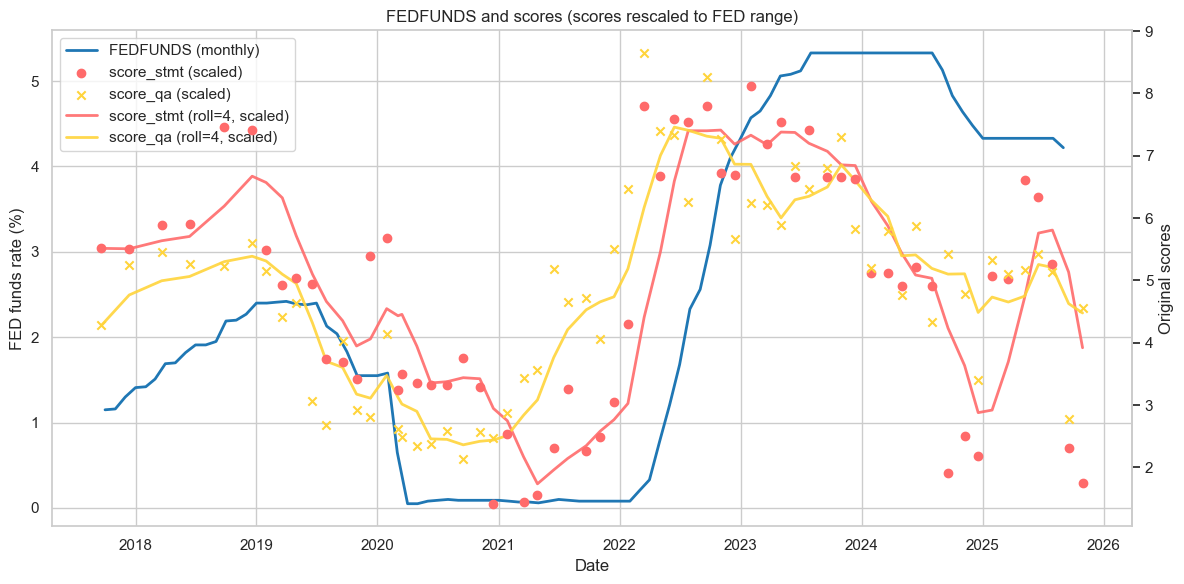

In [9]:
plot_fedfunds_aligned(df=pd.read_csv("data/_cache/full_sentiment/full_sentiment_cache.csv"),
                      fed_csv="data/rates/FEDFUNDS.csv",
                      outpath="outputs/Scores vs FedFunds Rate.png",
                      show_delta=False,
                      plot_mode='both',
                      ma_window=4)

=> Résultats cohérents : les scores ont l'air de coller aux vrais taux

## Features engineering

In [17]:
from src.quant_analysis.data_prep import load_event_data, add_tone_buckets, build_returns_long_format
from src.quant_analysis.visualization import plot_bucket_distributions_by_window, plot_window_distributions_by_bucket
df_raw = load_event_data(
    csv_path="data/_cache/full_sentiment/full_sentiment_cache.csv",
    symbols=["BTCUSDT", "ETHUSDT"],
    windows=[1,2,5,10,20],
)

df_bucketed = add_tone_buckets(
    df=df_raw,
    score_col="score_stmt",
    q=0.15,
    col_name="tone_bucket",
)

df_long = build_returns_long_format(
    df=df_bucketed,
    windows=[1,2,5,10,20],
    tone_col="tone_bucket",
)

In [3]:
df_bucketed

,meeting_date,score_stmt,score_qa,delta_score,BTCUSDT_1m_bps,BTCUSDT_2m_bps,BTCUSDT_5m_bps,BTCUSDT_10m_bps,BTCUSDT_20m_bps,ETHUSDT_1m_bps,ETHUSDT_2m_bps,ETHUSDT_5m_bps,ETHUSDT_10m_bps,ETHUSDT_20m_bps,tone_bucket
0,2017-12-13 00:00:00+00:00,5.500815,5.254919,-0.245896,-9.257370,-9.257370,-9.232656,11.524221,67.684006,8.252465,41.498900,32.969076,34.645151,225.543920,neutral
1,2018-03-21 00:00:00+00:00,5.894882,5.450313,-0.444569,-12.602871,-8.256024,8.304554,36.002923,-8.244937,-0.349638,14.150081,22.002593,43.956881,11.356589,neutral
2,2018-06-13 00:00:00+00:00,5.912300,5.269247,-0.643053,-3.791634,-13.494817,-4.459981,4.147396,-25.746086,-23.197463,-37.564674,-23.619733,-16.654549,-81.852383,neutral
3,2018-09-26 00:00:00+00:00,7.468491,5.231019,-2.237471,8.308523,3.669549,15.840343,21.320065,19.904244,4.690432,6.097132,21.557793,47.739490,47.739490,hawkish
4,2018-12-19 00:00:00+00:00,7.413429,5.601952,-1.811477,9.609694,9.609694,-37.100688,-133.728383,-127.322149,18.015460,18.962744,-48.518385,-138.565932,-130.870665,hawkish
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2025-05-07 00:00:00+00:00,6.608361,5.162253,-1.446109,-0.599629,-1.874219,-2.138019,23.663845,18.233398,-0.601591,-3.774215,-7.330937,10.494672,5.358031,neutral
57,2025-06-18 00:00:00+00:00,6.337618,5.430957,-0.906661,-11.086518,7.118989,33.206050,38.978780,78.851898,-13.939964,19.834929,110.904807,107.578864,142.406747,neutral
58,2025-07-30 00:00:00+00:00,5.265613,5.137869,-0.127744,4.957219,8.485784,13.504178,12.562518,27.948250,8.816376,12.531796,24.623888,29.710924,50.191836,neutral
59,2025-09-17 00:00:00+00:00,2.318388,2.779846,0.461458,-7.163534,-2.838954,3.215244,-1.340995,-24.895845,-9.320069,-4.536610,4.045631,-2.801781,-15.775804,dovish


In [4]:
df_long

,meeting_date,score_stmt,score_qa,delta_score,tone_bucket,symbol,horizon_min,return_bps
0,2017-12-13 00:00:00+00:00,5.500815,5.254919,-0.245896,neutral,BTCUSDT,1,-9.257370
1,2017-12-13 00:00:00+00:00,5.500815,5.254919,-0.245896,neutral,BTCUSDT,2,-9.257370
2,2017-12-13 00:00:00+00:00,5.500815,5.254919,-0.245896,neutral,BTCUSDT,5,-9.232656
3,2017-12-13 00:00:00+00:00,5.500815,5.254919,-0.245896,neutral,BTCUSDT,10,11.524221
4,2017-12-13 00:00:00+00:00,5.500815,5.254919,-0.245896,neutral,BTCUSDT,20,67.684006
...,...,...,...,...,...,...,...,...
300,2025-10-29 00:00:00+00:00,1.756583,4.561102,2.804519,dovish,BTCUSDT,1,-10.870753
301,2025-10-29 00:00:00+00:00,1.756583,4.561102,2.804519,dovish,BTCUSDT,2,-12.659733
302,2025-10-29 00:00:00+00:00,1.756583,4.561102,2.804519,dovish,BTCUSDT,5,-20.296667
303,2025-10-29 00:00:00+00:00,1.756583,4.561102,2.804519,dovish,BTCUSDT,10,-7.487120


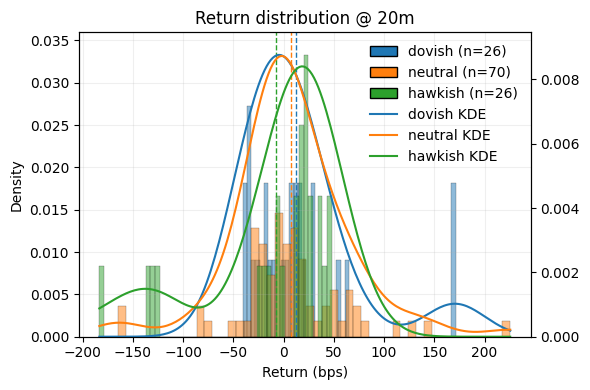

In [16]:
plot_bucket_distributions_by_window(
    df_long=df_long,
    horizon_min=20,
    buckets=("dovish", "neutral", "hawkish"),
    bins=50,
    plot_kde=True
)

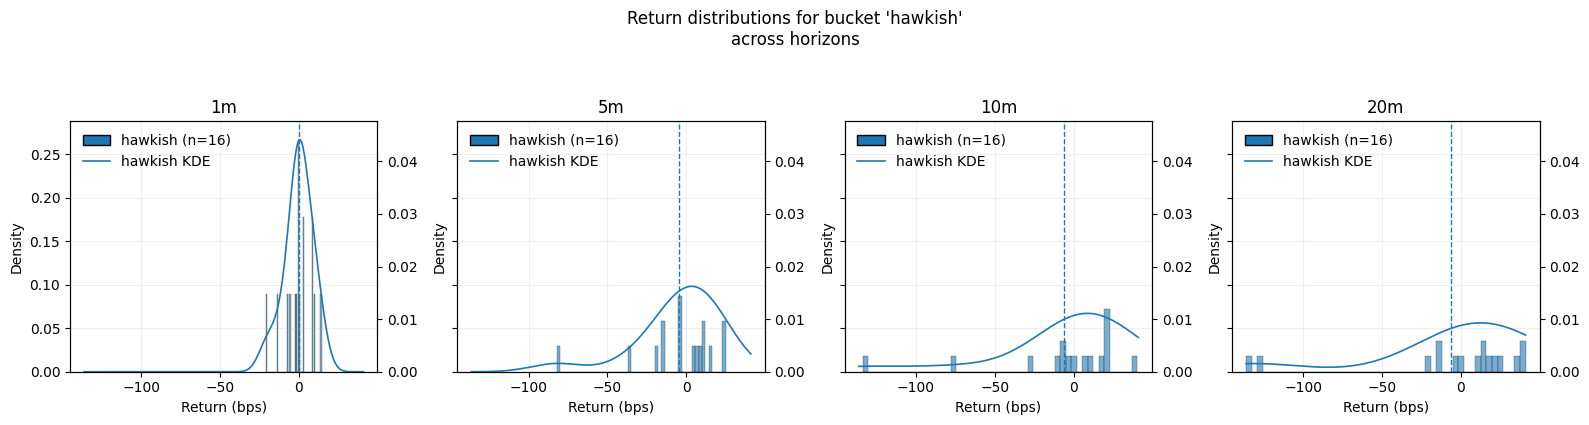

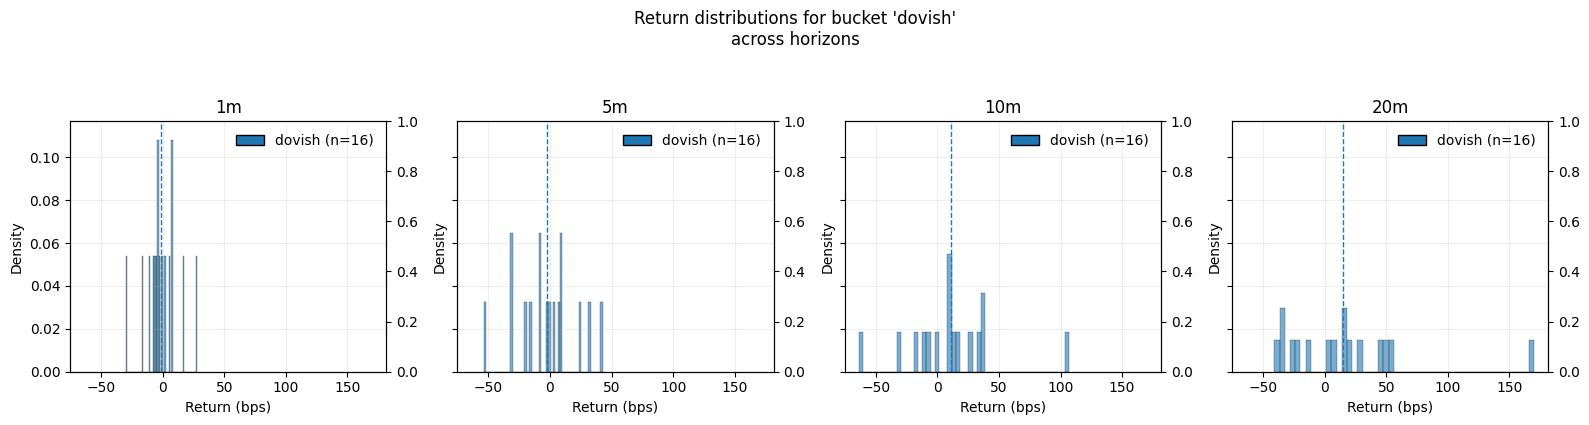

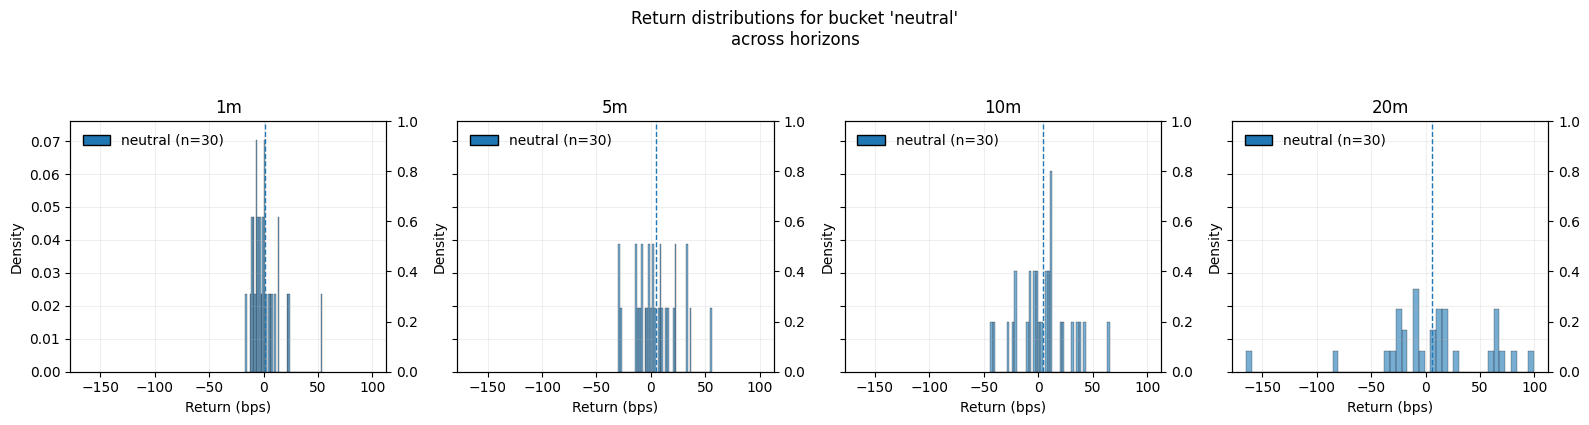

In [4]:
plot_window_distributions_by_bucket(
    df_long=df_long,
    tone_bucket="hawkish",
    windows=[1,5,10,20],
    bins=50,
    plot_kde=True
)
plot_window_distributions_by_bucket(
    df_long=df_long,
    tone_bucket="dovish",
    windows=[1,5,10,20],
    bins=50,
)
plot_window_distributions_by_bucket(
    df_long=df_long,
    tone_bucket="neutral",
    windows=[1,5,10,20],
    bins=50,
)